In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [1]:
'''
Função para imprimir os detalhes de uma imagem após a leitura 
img - matriz da imagem
desc -  comentario opcional sobre a imagem
'''
def printImgData(img, desc = None):
    if desc!=None:
        print(f'{desc}:: ', end='')
    print(f'Shape:{img.shape}, Min:{img.min():.4e}, Max:{img.max():.4e}, '
          f'Mean:{img.mean():.4e}, Type:{img.dtype}')

In [3]:
volume = np.load(fr"D:\microxplorer\TC3_Sapinho_20251028\imgOSSART.npz")
volume = volume['volume']
print(volume.shape, volume.dtype, volume.min(), volume.max())
imgSrc = volume

(400, 600, 600) float32 0.0 0.28786507


In [4]:
def gerarViews(volume, vmin, vmax):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(volume[volume.shape[0]//2, :, :], cmap='gray', vmin=vmin, vmax=vmax)
    ax[0].set_title('Axial View')
    ax[1].imshow(volume[:, volume.shape[1]//2, :], cmap='gray', vmin=vmin, vmax=vmax)
    ax[1].set_title('Coronal View')
    ax[2].imshow(volume[:, :, volume.shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)
    ax[2].set_title('Sagittal View')
    plt.show()

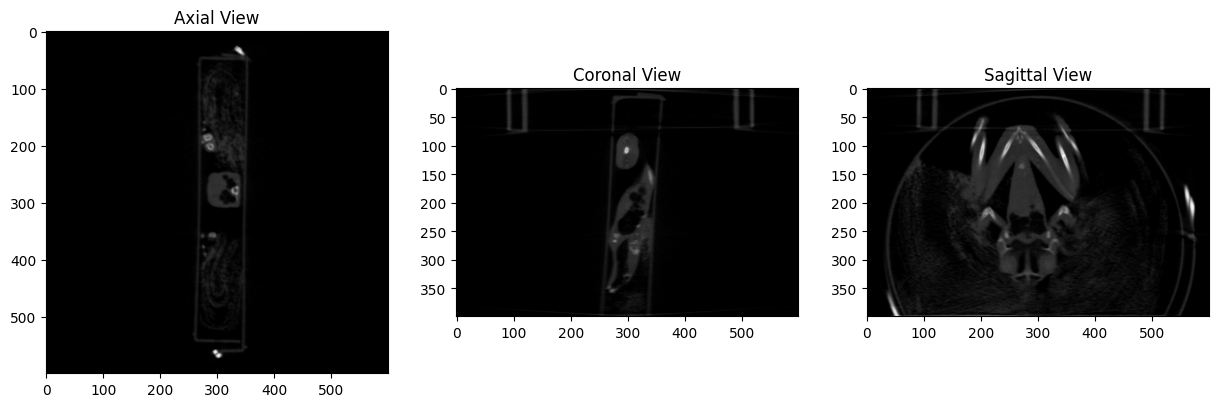

In [5]:
gerarViews(imgSrc, imgSrc.min(), imgSrc.max()*0.8)

In [7]:
mask = np.zeros_like(imgSrc, dtype=int)
printImgData(mask, 'Mask before creation')

Mask before creation:: Shape:(400, 600, 600), Min:0.0000e+00, Max:0.0000e+00, Mean:0.0000e+00, Type:int32


In [11]:
mask[30:360,140:410,260:360]= 1

In [22]:
croppedVolume = imgSrc * mask
printImgData(croppedVolume, 'Cropped Volume')

Cropped Volume:: Shape:(400, 600, 600), Min:0.0000e+00, Max:2.8787e-01, Mean:9.8173e-04, Type:float64


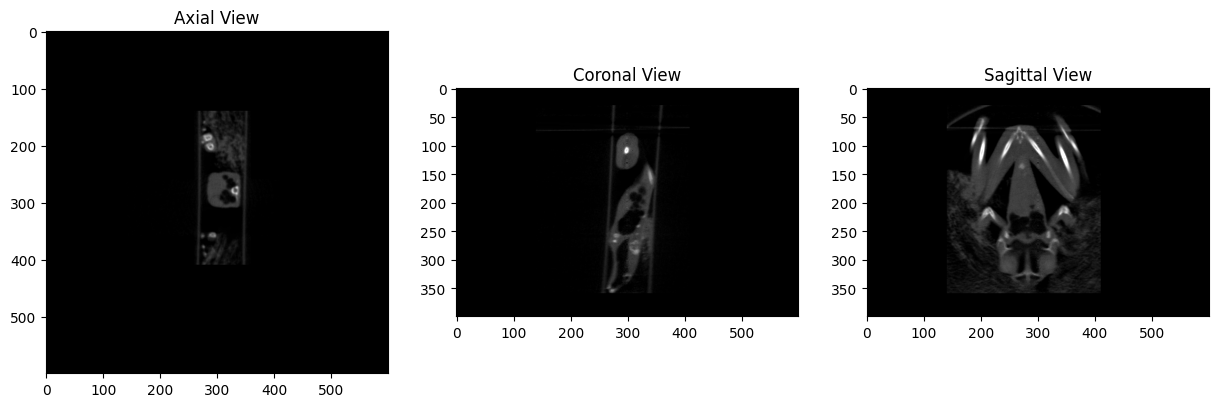

In [23]:
gerarViews(croppedVolume, 0, croppedVolume.max()*0.6)

In [25]:
minVal = croppedVolume.min()
maxVal = croppedVolume.max()
croppedVolume = (((croppedVolume-minVal)/(maxVal-minVal))*65535).astype("uint16")

printImgData(croppedVolume, 'Cropped Volume after rescale')

Cropped Volume after rescale:: Shape:(400, 600, 600), Min:0.0000e+00, Max:6.5535e+04, Mean:2.2345e+02, Type:uint16


In [26]:
croppedVolume[croppedVolume>65535*0.6]=65535
printImgData(croppedVolume, 'Cropped Volume after rescale')

Cropped Volume after rescale:: Shape:(400, 600, 600), Min:0.0000e+00, Max:6.5535e+04, Mean:2.2426e+02, Type:uint16


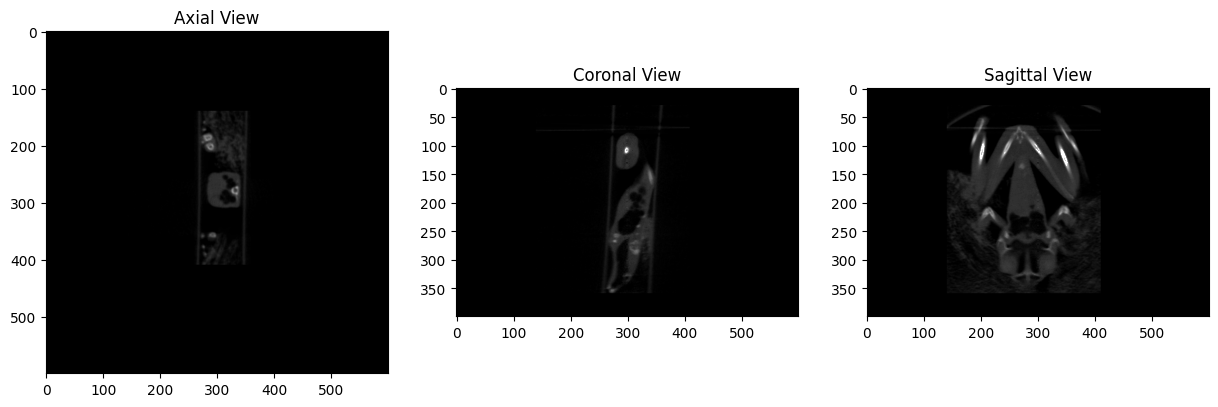

In [ ]:
gerarViews(croppedVolume, 0, croppedVolume.max())

In [54]:
def createFrame(img):
    img[img > 1] = 1
    img = (img)*255
    img = img.astype(np.uint8)

    return img

def CreateVideoViews(volume, viewType='axial', _time=20, _name='axial.mp4', 
                     _step=4, begin=0, final=0, verbose=False):    
    if viewType=='axial':
        if verbose:
            print('Creating axial video...')
        _length = (final-begin)
        framesNumber = (_length//1)
        width = volume.shape[1]
        height = volume.shape[2]
    elif viewType=='sagittal':   
        if verbose:
            print('Creating sagittal video...')
        _length = (final-begin)
        framesNumber = (_length//1)
        width = volume.shape[2]
        height = volume.shape[0]
    elif viewType=='coronal':
        if verbose:
            print('Creating coronal video...')
        _length = (final-begin)
        framesNumber = (_length//1)
        width = volume.shape[1]
        height = volume.shape[0]    

    
    time = _time
    fps = framesNumber/time

    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    video = cv.VideoWriter(_name, fourcc, float(fps), (width, height))

#print(framesNumber)

    for i in range(begin, final, _step):
        if viewType=='axial':
            img = createFrame(volume[i+begin, :, :]*1.25)        
        elif viewType=='sagittal':
            img = createFrame(volume[:, i+begin, :]*1.25)   
        elif viewType=='coronal':
            img = createFrame(volume[:, :, i+begin]*1.25)             
        if verbose:
            print(i, img.shape, img.max(), img.min(), img.mean(), np.isnan(img).sum())
        video.write(cv.cvtColor(img, cv.COLOR_GRAY2BGR))
        
    video.release() 

In [ ]:
CreateVideoViews(croppedVolume/65535, 
                 viewType='axial', 
                 _time=30, 
                 _name='cropped_axial.mp4', 
                 _step=2, begin=0, final=400)#, verbose=True)
CreateVideoViews(croppedVolume/65535, 
                 viewType='sagittal', 
                 _time=16, 
                 _name='cropped_sagittal.mp4', 
                 _step=1, begin=60, final=300)#, verbose=True)
CreateVideoViews(croppedVolume/65535, 
                 viewType='coronal', 
                 _time=10, 
                 _name='cropped_coronal.mp4', 
                 _step=1, begin=130, final=220)#, verbose=True)